# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import ilqr
from ilqr import iLQR
from ilqr.cost import QRCost
from ilqr.dynamics import constrain
from ilqr.examples.cartpole import CartpoleDynamics

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = dynamics.reduce_state(xs[-1])
    print("iteration", iteration_count, info, J_opt, final_state)

In [6]:
dt = 0.05
pole_length = 1.0
dynamics = CartpoleDynamics(dt, l=pole_length)

In [7]:
# Note that the augmented state is not all 0.
x_goal = dynamics.augment_state(torch.tensor([0.0, 0.0, 0.0, 0.0]))

# Instantenous state cost.
Q = torch.eye(dynamics.state_size)
Q[0, 0] = 1.0
Q[1, 1] = Q[4, 4] = 0.0
Q[0, 2] = Q[2, 0] = pole_length
Q[2, 2] = Q[3, 3] = pole_length**2
R = 0.1 * torch.eye(dynamics.action_size)

# Terminal state cost.
Q_terminal = 100 * torch.eye(dynamics.state_size)

# Instantaneous control cost.
R = torch.tensor([[0.1]])

cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

//anaconda3/lib/python3.7/site-packages/ilqr-0.2.0-py3.7.egg/ilqr/cost.py:435: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
//anaconda3/lib/python3.7/site-packages/ilqr-0.2.0-py3.7.egg/ilqr/cost.py:436: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
//anaconda3/lib/python3.7/site-packages/ilqr-0.2.0-py3.7.egg/ilqr/cost.py:441: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
//anaconda3/lib/python3.7/site-packages/ilqr-0.2.0-py3.7.egg/ilqr/cost.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

In [8]:
N = 10
x0 = dynamics.augment_state(torch.tensor([0.0, 0.0, np.pi, 0.0]))
us_init = torch.rand((N, dynamics.action_size)) * 2 - 1
ilqr = iLQR(dynamics, cost, N)

In [9]:
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=500, on_iteration=on_iteration)

//anaconda3/lib/python3.7/site-packages/ilqr-0.2.0-py3.7.egg/ilqr/controller.py:373: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor([[ 0.0000e+00,  0.0000e+00, -8.7423e-08, -1.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  3.2960e-04, -1.5100e-07, -1.0000e+00,  2.4716e-04],
        [ 1.6480e-05,  3.7531e-04, -1.2549e-05, -1.0000e+00,  2.8139e-04],
        [ 3.5245e-05,  2.0514e-03, -2.6615e-05, -1.0000e+00,  1.5338e-03],
        [ 1.3781e-04,  7.4068e-04, -1.0339e-04, -1.0000e+00,  5.4102e-04],
        [ 1.7485e-04, -8.3836e-04, -1.3033e-04, -1.0000e+00, -6.8128e-04],
        [ 1.3293e-04, -1.6480e-03, -9.6234e-05, -1.0000e+00, -1.3364e-03],
        [ 5.0530e-05, -6.8821e-03, -2.9476e-05, -1.0000e+00, -5.2974e-03],
        [-2.9357e-04, -9.9469e-03,  2.3541e-04, -1.0000e+00, -7.6069e-03],
        [-7.9092e-04, -1.0476e-02,  6.1575e-04, -1.0000e+00, -7.9170e-03],
        [-1.3147e-03,  3.1306e-04,  1.0115e-03, -1.0000e+00,  4.0114e-04]]) tensor([[ 0.0068],
        [ 0.0009],
        [ 0.0344],
        [-0.0269],
        [-0.0323],
        [-0.0165],
        [-0.1076],
        [-0.0629],
        [-0.0110],
   

tensor([[ 0.0000e+00,  0.0000e+00, -8.7423e-08, -1.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -2.3947e-03, -1.5100e-07, -1.0000e+00, -1.7961e-03],
        [-1.1974e-04,  3.0131e-02,  8.9733e-05, -1.0000e+00,  2.2598e-02],
        [ 1.3868e-03, -4.8491e-03, -1.0401e-03, -1.0000e+00, -3.6039e-03],
        [ 1.1444e-03, -1.5556e-02, -8.5989e-04, -1.0000e+00, -1.2017e-02],
        [ 3.6653e-04, -1.3226e-02, -2.5907e-04, -1.0000e+00, -1.0585e-02],
        [-2.9478e-04, -4.9045e-02,  2.7022e-04, -1.0000e+00, -3.7545e-02],
        [-2.7470e-03, -2.3707e-02,  2.1476e-03, -1.0000e+00, -1.8442e-02],
        [-3.9324e-03, -4.1528e-03,  3.0695e-03, -1.0000e+00, -2.9865e-03],
        [-4.1400e-03,  3.1731e-02,  3.2188e-03, -9.9999e-01,  2.5055e-02],
        [-2.5534e-03,  1.1403e-02,  1.9661e-03, -1.0000e+00,  1.0993e-02]]) tensor([[-0.0491],
        [ 0.8049],
        [-0.9018],
        [-0.2223],
        [ 0.0484],
        [-0.9376],
        [ 0.5753],
        [ 0.4228],
        [ 0.9360],
   

//anaconda3/lib/python3.7/site-packages/ilqr-0.2.0-py3.7.egg/ilqr/controller.py:169: UserWarning: exceeded max regularization term


In [ ]:
# Reduce the state to something more reasonable.
xs = dynamics.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)

In [ ]:
t = np.arange(N + 1) * dt
x = xs[:, 0]
x_dot = xs[:, 1]
theta = np.unwrap(xs[:, 2])  # Makes for smoother plots.
theta_dot = xs[:, 3]

In [32]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")

NameError: name 'theta' is not defined

In [33]:
_ = plt.plot(t, theta)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Orientation (rad)")
_ = plt.title("Orientation path")

NameError: name 't' is not defined

In [34]:
_ = plt.plot(t[:-1], us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

NameError: name 't' is not defined

In [35]:
_ = plt.plot(t, x)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Position (m)")
_ = plt.title("Position path")

NameError: name 't' is not defined

In [36]:
_ = plt.plot(t, x_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Velocity (m)")
_ = plt.title("Velocity path")

NameError: name 't' is not defined

In [37]:
_ = plt.plot(t, theta_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Angular velocity (rad/s)")
_ = plt.title("Angular velocity path")

NameError: name 't' is not defined

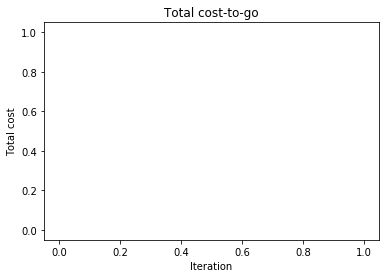

In [38]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")